In [ ]:
!pip install spmsimu

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import random

from spmsimu.simulator import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 54.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.4/578.4 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━

Generate simulated data for training. Can also use the trained data in the repository

In [ ]:
import pickle
checkerboard = generate_pattern(nx=128, ny=128, pattern='atomic', num=10, show=False)
kernel_size = 100 # size of kernel in pixels
for i in range(10):
  results = []
  for ii in tqdm(range(1000)):
    wx1 = np.random.randint(20)
    wy1 = np.random.randint(20)
    wx2 = np.random.randint(20)
    wy2 = np.random.randint(20)
    amp1 = 1
    amp2 = np.random.rand()
    offset = np.random.randint(30)
    tip_double = generate_doubletip_kernel(kernel_size=kernel_size, offset=offset,tip1=[wx1, wy1, amp1], tip2=[wx2, wy2, amp2])

    checkerboard_scan = tip_scan(checkerboard, tip_double)

    result = {'wx1': wx1, 'wy1':wy1, 'wx2':wx2, 'wy2':wy2, 'amp1':amp1, 'amp2':amp2, 'offset':offset, 'tip': tip_double, 'scan':checkerboard_scan}
    results.append(result)
  pickle.dump(results, open(f'/content/drive/MyDrive/complex_tip_scan_1000_{i}.pkl', 'wb'))

Model training routine

In [ ]:
def general_train(model, in_sample, out_sample, train_loader, test_loader, number_of_epochs, criterion, optimizer, device):
  loss_history = []
  for epoch in range(number_of_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch")
    for di, data in enumerate(progress_bar):

        inputs, labels = in_sample(data), out_sample(data)  # Ignore labels since this is an autoencoder

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.to(device))  # Compare output with input
        #loss = loss*((1-labels.to("cuda"))*0.5+0.5)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Record and print the average loss for this epoch
        epoch_loss = running_loss / (di+1)

        progress_bar.set_postfix(loss=f'Epoch [{epoch+1}/{num_epochs}], Batch {di}/{len(train_loader)} Loss: {epoch_loss:.5f}')
    test_loss = 0.0
    model.eval()
    for data in test_loader:
        inputs, labels = in_sample(data), out_sample(data)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels.to(device))
        test_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss / len(test_loader):.5f}')
    loss_history.append([epoch_loss, test_loss/len(test_loader)])
  return model, loss_history

Data preprocessing

In [ ]:
import glob
import torch
import pickle
inputs = []
targets = []
### CHANGE FILE PATH! ####
for fn in glob.glob('/content/drive/MyDrive/complex_tip_scan_1000*.pkl'):
  data = pickle.load(open(fn, 'rb'))
  input = np.array([d['scan'] for d in data])
  input = torch.from_numpy(input)
  target = torch.tensor([d['tip'] for d in data])
  inputs.append(input)
  targets.append(target)
inputs = torch.cat(inputs, dim=0)
targets = torch.cat(targets, dim=0)
length = len(inputs)
min_vals = inputs.view(len(inputs), -1).min(dim=1).values.view(-1, 1, 1)  # Shape: (5000, 1, 1)
max_vals = inputs.view(len(inputs), -1).max(dim=1).values.view(-1, 1, 1)  # Shape: (5000, 1, 1)
inputs = (inputs - min_vals) / (max_vals - min_vals)
min_vals = targets.view(len(inputs), -1).min(dim=1).values.view(-1, 1, 1)  # Shape: (5000, 1, 1)
max_vals = targets.view(len(inputs), -1).max(dim=1).values.view(-1, 1, 1)  # Shape: (5000, 1, 1)
targets = (targets-min_vals)/(max_vals-min_vals)


inputs = inputs.unsqueeze(1)
targets = targets.unsqueeze(1)
print('original dataset size',inputs.shape, targets.shape)

#Resize target PSFs to 128x128
#Some of the PSFs can be corrupted so remove them
targets = torch.nn.functional.interpolate(targets, size=(128, 128), mode='bilinear')
mask = [~torch.isnan(t).any() for t in targets]
targets = targets[mask]
inputs = inputs[mask]
print('final dataset size',inputs.shape, targets.shape)

Model architecture

In [ ]:
#a autoencoder architecture with residual block
from torch import nn
class ResNetBlock(nn.Module):
    """
    Basic Residual block for ResNet architecture
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Downsample layer (if needed for skip connection)
        self.downsample = downsample
    def forward(self, x):
        identity = x  # Save the input for the skip connection
        # Pass through the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # Apply the downsample layer if dimensions differ
        if self.downsample is not None:
            identity = self.downsample(x)
        # Add the skip connection
        out = out + identity
        out = self.relu(out)
        return out
class Res_autoencoder(nn.Module):
    def __init__(self):
        super(Res_autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            ResNetBlock(1,32,stride=2,downsample = nn.AvgPool2d(2)),
            ResNetBlock(32,32,stride=2,downsample = nn.AvgPool2d(2)),
            ResNetBlock(32,32,stride=2,downsample = nn.AvgPool2d(2)),
            nn.Conv2d(32, 8, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Linear(8 * 8 * 8, 64)  # Flatten to latent space

        # Decoder
        self.fc2 = nn.Linear(64, 8 *8*8)  # Expand back to spatial dimensions
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        # Decode
        x = self.fc2(x)
        x = x.view(x.size(0), 8, 8, 8)  # Reshape to match decoder input
        x = self.decoder(x)
        return x

class Y_autoencoder(nn.Module):
    def __init__(self):
        super(Y_autoencoder, self).__init__()
        # Encoder
        self.encoder0 = nn.Sequential(
            ResNetBlock(1,32,stride=2,downsample = nn.AvgPool2d(2)),
            ResNetBlock(32,32,stride=2,downsample = nn.AvgPool2d(2)),
            ResNetBlock(32,32,stride=2,downsample = nn.AvgPool2d(2)),
            nn.Conv2d(32, 8, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )
        self.fc0 = nn.Linear(8 * 8 * 8, 64)  # Flatten to latent space
        # Encoder
        self.encoder1 = nn.Sequential(
            ResNetBlock(1,32,stride=2,downsample = nn.AvgPool2d(2)),
            ResNetBlock(32,32,stride=2,downsample = nn.AvgPool2d(2)),
            ResNetBlock(32,32,stride=2,downsample = nn.AvgPool2d(2)),
            nn.Conv2d(32, 8, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Linear(8 * 8 * 8, 64)  # Flatten to latent space
        # Decoder
        self.fc2 = nn.Linear(128, 8 *8*8)  # Expand back to spatial dimensions
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode
        x0 = self.encoder0(x[0])
        x0 = x0.view(x0.size(0), -1)  # Flatten
        x0 = self.fc0(x0)

        x1 = self.encoder1(x[1])
        x1 = x1.view(x1.size(0), -1)  # Flatten
        x1 = self.fc1(x1)

        x = torch.cat([x0, x1], dim=1)
        # Decode
        x = self.fc2(x)
        x = x.view(x.size(0), 8, 8, 8)  # Reshape to match decoder input
        x = self.decoder(x)
        return x

Train the model - using only real-space image as input

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, Subset
from tqdm import tqdm
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


triplets = TensorDataset(inputs, targets)
conv_autoencoder = Res_autoencoder().to("cuda")
criterion = torch.nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=0.0002)

num_epochs =  75
#torch.manual_seed(42)
indices = torch.randperm(len(triplets))
train_size = int(0.9*len(triplets))
print('train_size', train_size)

# Split the indices into training and test sets
train_indices = indices[:train_size]  # First 90% for training
test_indices = indices[train_size:]   # Last 10% for testing

# Use the indices to split the data
train_data = Subset(triplets, train_indices)
test_data = Subset(triplets, test_indices)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
ae_in_sample = lambda x: x[0].to("cuda").float()
ae_out_sample = lambda x: x[1].to("cuda").float()
conv_autoencoder, loss_history = general_train(conv_autoencoder, ae_in_sample, ae_out_sample, train_loader, test_loader, num_epochs, criterion, optimizer, device)

Train the model - using both real-space image and FFT of the images as dual input

In [ ]:
# generate ffts
from scipy.signal.windows import hann
from torchvision.transforms import GaussianBlur
def image_fft(img):

  blur = GaussianBlur(kernel_size=5, sigma=0.5)
  img = blur(img)
  fft_scan = np.fft.fft2(img)
  fft_log = np.log(1+np.abs(np.fft.fftshift(fft_scan)))
  return img
ffts = [image_fft(img) for img in inputs]

In [ ]:
#Y_autoencoder
from torch.utils.data import DataLoader, TensorDataset, Subset
from tqdm import tqdm
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#inputs_log = (torch.log10(inputs+1e-3)+3)/3
#targets_log = (torch.log10(targets+1e-3)+3)/3

triplets = TensorDataset(inputs, ffts, targets)
y_autoencoder = Y_autoencoder().to("cuda")
criterion = torch.nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(y_autoencoder.parameters(), lr=0.0002)

num_epochs =  75
torch.manual_seed(42)
indices = torch.randperm(len(triplets))
train_size = int(0.9*len(triplets))
print('train_size', train_size)

# Split the indices into training and test sets
train_indices = indices[:train_size]  # First 90% for training
test_indices = indices[train_size:]   # Last 10% for testing

# Use the indices to split the data
train_data = Subset(triplets, train_indices)
test_data = Subset(triplets, test_indices)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
ae_in_sample = lambda x: (x[0].to("cuda").float(), x[1].to("cuda").float())
ae_out_sample = lambda x: x[2].to("cuda").float()
y_autoencoder, loss_history = general_train(y_autoencoder, ae_in_sample, ae_out_sample, train_loader, test_loader, num_epochs, criterion, optimizer, device)

See the results (only on real-space image autoencoder here, dual-input autoencoder is similar)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([1, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0061, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
tensor(0.0140, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
tensor(0.0240, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)
tensor(0.0013, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)


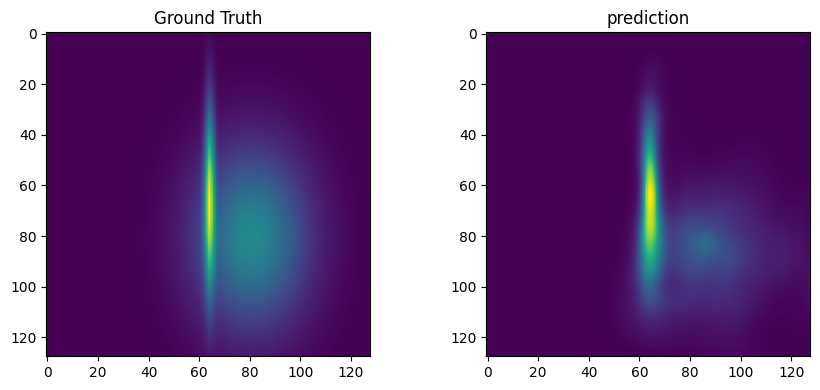

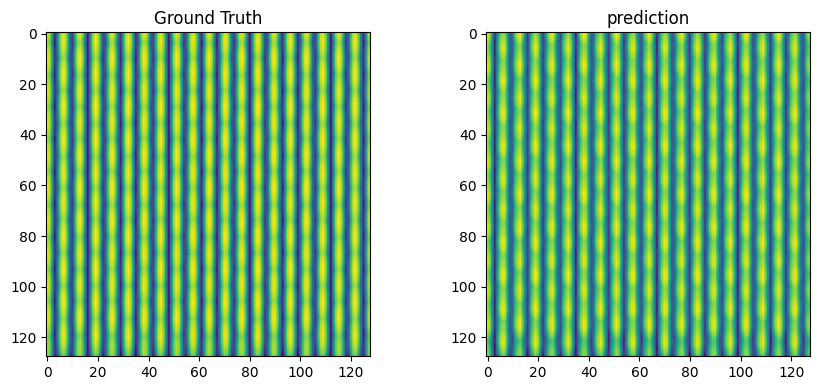

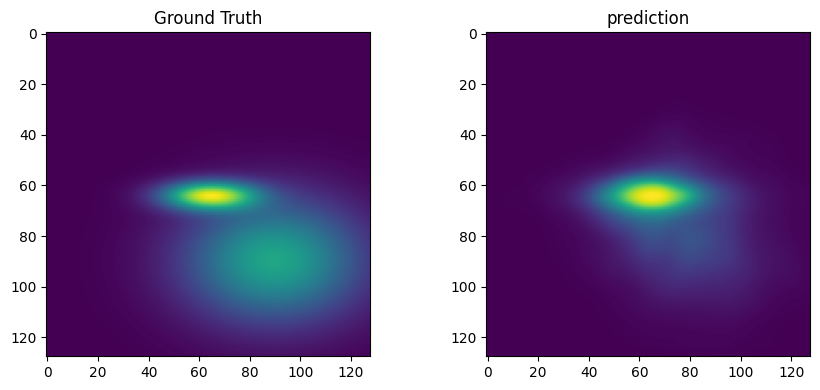

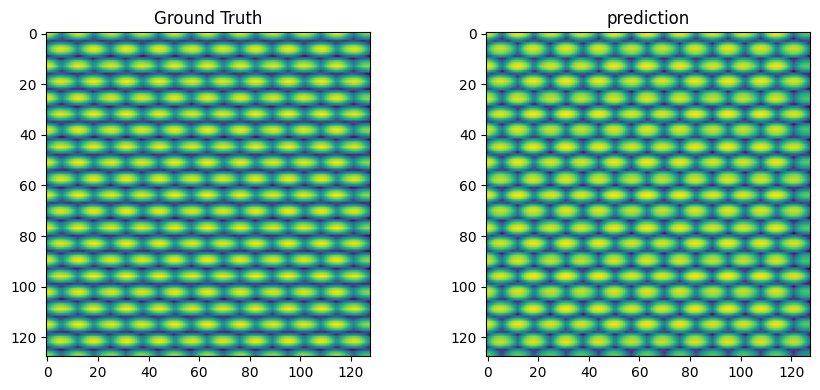

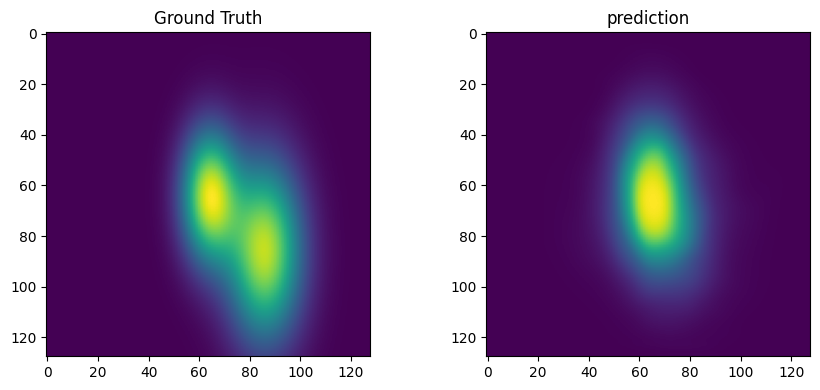

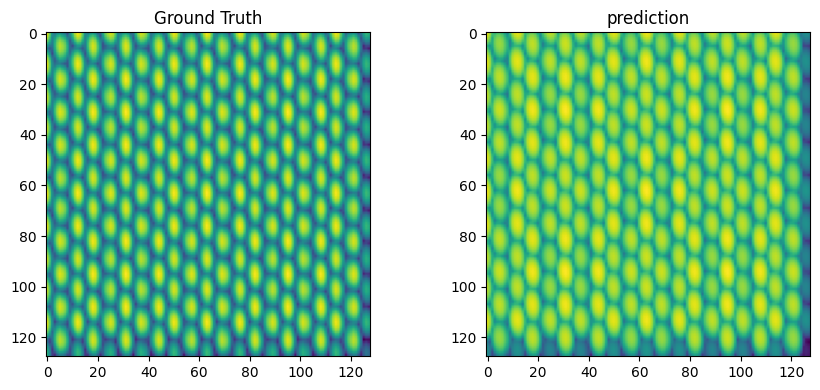

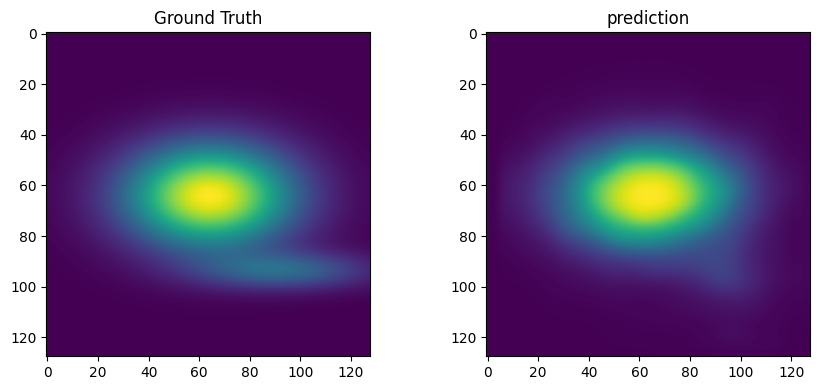

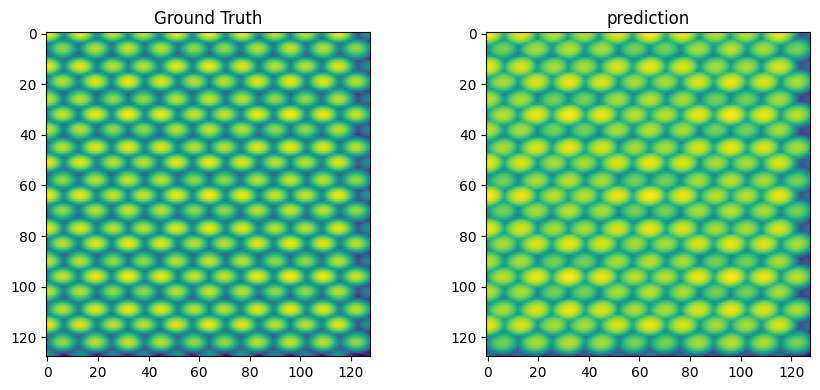

In [ ]:
#normal
for i in range(30, 34):

  checkerboard_scan = test_data[i][0]
  checkerboard_scan_normalized = checkerboard_scan
  prediction = conv_autoencoder(checkerboard_scan_normalized.unsqueeze(0).cuda().float())
  print(criterion(prediction.cuda(),test_data[i][1].cuda()))
  prediction = prediction.cpu().squeeze().detach().numpy().squeeze()

  fig, ax=plt.subplots(1,2,figsize=[9,4])
  ax[0].imshow(test_data[i][1].squeeze().numpy())
  ax[1].imshow(prediction)

  ax[0].set_title('Ground Truth')
  ax[1].set_title('prediction')

  plt.tight_layout()

  checkerboard = generate_pattern(nx=128, ny=128, pattern='atomic', num=10, show=False)
  fig, ax=plt.subplots(1,2,figsize=[9,4])
  tip = prediction
  tip = cv2.resize(tip,(100,100))
  scan = tip_scan(checkerboard, tip)
  ax[1].imshow(scan)
  ax[0].imshow(checkerboard_scan[0])

  ax[0].set_title('Ground Truth')
  ax[1].set_title('prediction')

  plt.tight_layout()